# Training and Deployment:

**Multi-label audio classification fastai2 with Amazon SageMaker**

The following notebook is based on the AWS demo fastai2 project (with thanks to Matt McClean for the setup instructions):

https://github.com/mattmcclean/fastai2-sagemaker-deployment-demo

We now need to train and deploy the fastai2 model on Amazon SageMaker. This notebook runs within a fastai2 kernel and environment created by a CloudFormation stack (details in the link below).

Using the steps outlined in the above demo repo the notebook will:

1. train a model locally with a SageMaker notebook instance
2. export our model and upload the model artefacts to S3 
3. deploy the model locally to the same notebook instance to test and 
4. deploy the endpoint to Amazon SageMaker to be deployed in a production setting.

**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio

The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [ ]:
pip install git+https://github.com/rbracco/fastai2_audio.git

In [ ]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)

!conda install -c conda-forge libsndfile --yes

## Train the fastai model locally
First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [1]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [2]:
# Create train_curated Dataframe

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

def create_train_noisy_df(file, remove_files=[]):
    df_noisy = pd.read_csv(file)
    df_noisy.set_index('fname', inplace=True)
    df_noisy.loc[remove_files]
    df_noisy.drop(index=remove_files, inplace=True)
    df_noisy.reset_index(inplace=True)
    return df_noisy

In [3]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
df_curated = create_train_curated_df('../data/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [4]:
# Create train_noise Dataframe
df_noisy = create_train_curated_df('../data/train_noisy.csv')
df_noisy.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [5]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,4262fa88.wav,Scissors
freq,1,75


In [6]:
df_noisy.describe()

,fname,labels
count,19815,19815
unique,19815,1168
top,c049d1b3.wav,Waves_and_surf
freq,1,291


**Now define the data paths**

First we're going to try to train with the curated train set only to see the performance. Then we can mix both the curated and noise train set to see the results.

In [7]:
# Grab the audio files

audio_extensions[:5]

('.aif', '.aifc', '.aiff', '.au', '.mp2')

In [8]:
fnames = df_curated['fname']

In [9]:
fnames[:5]

0    0006ae4e.wav
1    0019ef41.wav
2    001ec0ad.wav
3    0026c7cb.wav
4    0026f116.wav
Name: fname, dtype: object

In [10]:
#from tqdm import tqdm
#for ind in tqdm(df_curated.index):
fdir = '../data/train_curated'
fpaths = [Path(fdir,df_curated['fname'][ind]) for ind in df_curated.index]

In [11]:
len(fpaths)

4964


# Preparing the dataset

We will use the fastai2 AudioConfig class which allows us to gain mel-spectrogram image tensors from the audio files using the module: *BasicMelSpectrogram*

In this instance, the files have the following constant parameters which these do not need to be changed:

* bitrate = 16
* channels = 1, so no downmixing required
* sample

However, we will change the following:

* sample rate = 44.1Khz, which will be downsampled to 16kHz or 22kHz as appropriate

In [12]:
cfg = AudioConfig.BasicMelSpectrogram()

Our configuration will limit options like the frequency range and the sampling rate

In [13]:
cfg.f_max, cfg.sample_rate

(None, 16000)

We can then create transform from the config settings in order to convert the audio file in a mel-spectrogram (default settings for now). 

We can also set a crop size for the audio, in order to create uniform sized mel-spectrogram tensors to feed to the model.

In [14]:
aud2spec = AudioToSpec.from_cfg(cfg)
crop = CropSignal(5000)

Now we can make a data pipeline that takes the files, crops them and converts them to mel-spectrograms.

In [15]:
pipe = Pipeline([AudioTensor.create, crop, aud2spec])

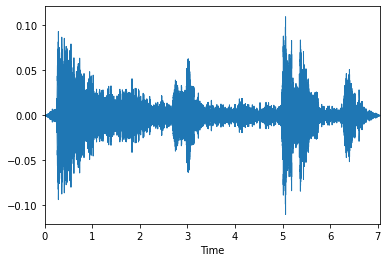

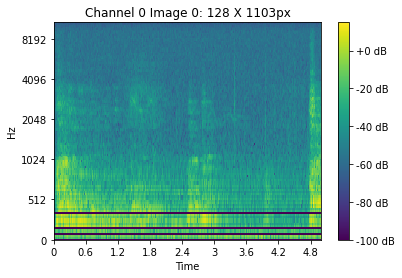

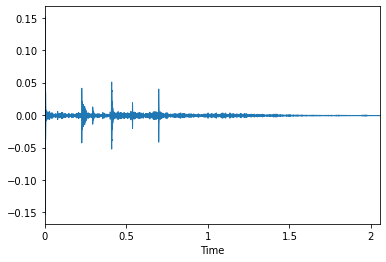

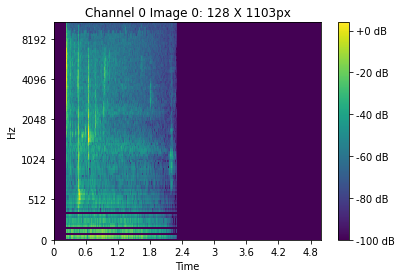

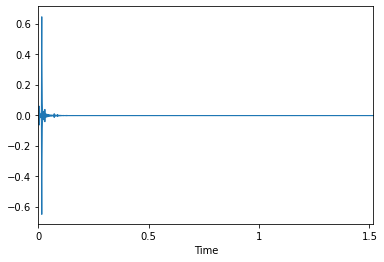

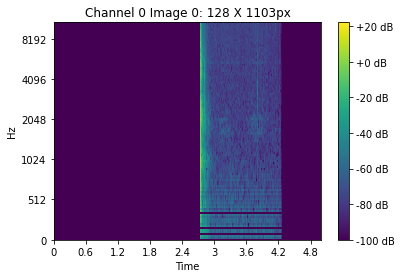

In [16]:
for fn in fpaths[:3]:
    audio = AudioTensor.create(fn)
    audio.show()
    pipe(fn).show()

## Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


In [17]:
dsets = DataBlock().datasets(df_curated)

this contains a train and a “valid” dataset, which we can index into:

In [18]:
dsets.train[0]

(fname        23ef72c2.wav
 labels    Chirp_and_tweet
 Name: 678, dtype: object,
 fname        23ef72c2.wav
 labels    Chirp_and_tweet
 Name: 678, dtype: object)

As you can see, this simply returns a row of the dataframe, twice. This is because by default, the datablock assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions:

lambda functions are great for quickly iterating, however they are not compatible with serialization, so we advise you to use the more verbose approach if you want to export your Learner after training (they are fine if you are just experimenting).

We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable (label) will need to be split on the comma character so that it becomes a list, for the multi-label classification:

In [50]:
def get_x(r): return '../data/train_curated/'+r['fname']
def get_y(r): return r['labels'].split(',')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df_curated)
dsets.train[0]

('../data/train_curated/e6b5c733.wav', ['Cupboard_open_or_close'])

# Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [20]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [21]:
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 400,
 'win_length': 400,
 'hop_length': 200,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None,
 'sr': 44100,
 'nchannels': 1}

In [22]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [23]:
item_tfms = [RemoveSilence(), CropSignal(2000, pad_mode='Repeat'), aud2spec, MaskTime(size=30), MaskFreq(size=10)]

Now let's build our `DataBlock`

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

In [24]:
aud_digit = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                      get_x = get_x,
                      get_y=get_y,
                      splitter=RandomSplitter(),
                      item_tfms = item_tfms)

dsets = aud_digit.datasets(df_curated)
dsets.train[0]

(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [54]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

TypeError: where(): argument 'condition' (position 1) must be Tensor, not bool

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [26]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(),
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

dls = dblock.dataloaders(df_curated, bs=64)

Let's look at some augmented data:

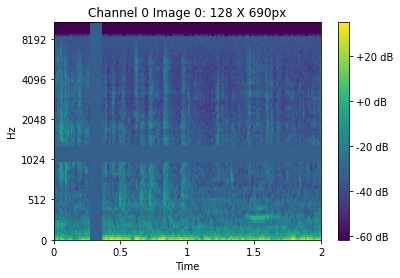

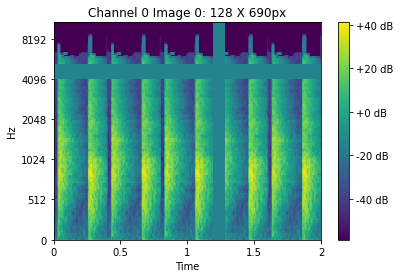

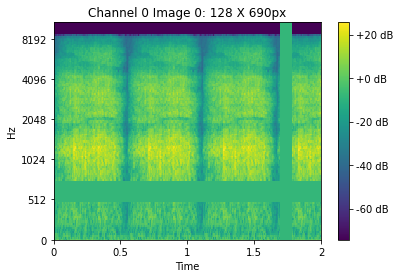

Child_speech_and_kid_speaking
Clapping
Hiss


In [27]:
dls.show_batch(max_n=3)

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes; vc

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner:

In [28]:
def alter_learner(learn, n_channels=1):
    "Adjust a `Learner`'s model to accept `1` channel"
    layer = learn.model[0][0]
    layer.in_channels=n_channels
    layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
    learn.model[0][0] = layer

In [34]:
def audio_learner(dls, arch, metrics):
    "Prepares a `Learner` for audio processing"
    learn = Learner(dls, arch, metrics=metrics)
    n_c = dls.one_batch()[0].shape[1]
    if n_c == 1: alter_learner(learn)
    return learn.to_fp16()

**Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

Firt, let's train our model, setting accuracy threshold to 0.2 for our metric:

In [35]:
loss_func = nn.BCEWithLogitsLoss() #Binary Cross Entropy With Loss function = Sigmoid with Binary Cross Entropy Loss

learn = audio_learner(dls, xresnet18(), metrics=partial(accuracy_multi, thresh=0.2))

In [36]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 1000])

The above should be `[batch_size, no. categories]` - so we have a problem with the number of categories recognised

In [32]:
activs[0]

tensor([ 1.2992e+00, -3.4458e-01,  5.6599e-01, -7.4928e-03, -6.0537e-01,
         1.3872e-01, -6.4365e-01,  5.5697e-01,  2.3643e-01, -4.5860e-02,
         7.8527e-01, -7.1185e-01,  1.7596e-02,  3.4639e-02,  5.9055e-01,
        -3.8859e-01,  8.6529e-02,  9.3258e-01, -5.8628e-01, -3.6175e-01,
        -1.5986e-01,  9.6307e-02,  3.2760e-02,  1.8992e-01, -4.9704e-01,
        -4.7097e-01,  8.0018e-01, -2.7827e-01, -9.0236e-01,  9.8829e-01,
        -1.6231e-01, -9.3722e-01, -1.3841e+00, -1.2752e-01,  8.3486e-01,
        -3.5912e-01,  3.3010e-01, -7.9831e-01, -8.3151e-01, -2.7310e-01,
        -1.8089e-01,  4.0588e-01,  3.8302e-01,  3.5018e-01,  1.5957e-01,
        -1.3189e+00, -1.5664e-01,  2.4985e-01, -2.1746e-01, -4.4731e-01,
         6.8326e-01, -6.8919e-01, -1.0971e+00, -1.6356e-02, -1.5436e-01,
         8.1388e-02,  1.0775e+00,  1.1092e-01, -2.0403e-01,  6.3838e-01,
         8.3702e-01, -4.6162e-02,  1.6212e-01,  2.8508e-01, -5.7465e-01,
        -7.6034e-02,  9.9511e-01,  1.5169e-01, -1.1

Since we have a one-hot encoded target, we will use BCEWithLogitsLoss.

In [33]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

ValueError: Target size (torch.Size([64, 80])) must be the same as input size (torch.Size([64, 1000]))

In [ ]:
learn.lr_find()

**Now we need to grab our number of channels and alter our learne's first hannel to accept this, as CNN's typically accept 3 channels (RGB):**

In [ ]:
n_c = dls.one_batch()[0].shape[1]; n_c

In [ ]:
alter_learner(learn, n_c)

We can then find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

# create the image data loader
dls = ImageDataLoaders.from_path_re(path, get_image_files(path), pat=r'(.+)_\d+.jpg$', 
                                    item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=64,
                                    batch_tfms=[*aug_transforms(size=299, max_warp=0),
                                    Normalize.from_stats(*imagenet_stats)])
# create the learner
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(1)

## Export the model and upload to S3

Now that we have trained our model we will export it using the learner method `export()` and upload the exported model to S3.

In [ ]:
learn.export()

Now let's create a tarfile for our model.

In [ ]:
import tarfile
with tarfile.open(path/'model.tar.gz', 'w:gz') as f:
    f.add(path/'export.pkl', arcname='model.pkl')

In [ ]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

In [ ]:
prefix = 'DEMO-fastai2-sagemaker-oxford-pets'

Now we will upload the model to the default S3 bucket for sagemaker.

In [ ]:
model_location = sess.upload_data(str(path/'model.tar.gz'), key_prefix=prefix)
model_location

## Script for model inference

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the `model_fn()` is called to determine how to load your trained model. The `model_fn()` along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* `model_fn(model_dir)` - loads your model.
* `input_fn(serialized_input_data, content_type)` - deserializes predictions to predict_fn.
* `output_fn(prediction_output, accept)` - serializes predictions from predict_fn.
* `predict_fn(input_data, model)` - calls a model on data deserialized in input_fn.

Here is the full code in a file `serve.py` showing implementations of the 4 key functions:

In [ ]:
!pygmentize scripts/serve.py

## Deploy locally to test

Before deploying to Amazon SageMaker we want to verify that the endpoint is working properly. The Amazon SageMaker Python SDK allows us to deploy locally to the Notebook instance using Docker. We will create the model then specify the parameter `instance_type` to be `local` telling the SDK to deploy locally.

In [ ]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now that we have created the model we will deploy locally to test. It may take a while to run the first time as we need to download a Docker image to our notebook instance.

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

Now we can test out our endpoint. We will download a cat images from the internet and save locally.

In [ ]:
! [ -d tmp ] || mkdir tmp
! wget -q -O tmp/british-shorthair.jpg https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg

In [ ]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now we can call our local endpoint to ensure it is working and provides us the correct result.

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

Once you are happy that the endpoint is working suceessully you can shut it down.

In [ ]:
predictor.delete_endpoint()

## Deploy to SageMaker

Once we have verified that the script is working successfully on our locally deployed endpoint we can deploy our model to Amazon SageMaker so that it can be used in a production application. The code is almost exactly the same as deploying locally except that when we call `model.deploy()` we will change the instance type to an Amazon SageMaker valid instance type (e.g. `ml.m5.xlarge`).

In [ ]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now let's deploy our SageMaker endpoint. It will take a few min to provision.

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [ ]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now let's test our remote endpoint running on SageMaker hosting services.

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

## Optional: delete endpoint

If you do not want to keep the endpoint up and running then remember to delete it to avoid incurring further costs.

In [ ]:
predictor.delete_endpoint()